# Comp 540 Blog Post 3

One of the major problems noted with this competition has been generalizing to unseen image modalities (images taken from different kinds of microscopes). The planned stage 2 dataset for this competition will consist of a new test set with modalities not even in the train data. Because of that, normalization of images is necessary. Some crude techniques involve simply inverting images with white backgrounds to make them similar to those with the black background. In this blog post, we explore a more sophisticated technique. We'll apply neural style transfer to transform an image from 1 modality to another.

## How does neural style transfer work?

**Neural-Style** transfer is a neural network based algorithm that takes as input

* a content-image
* a style image

and returns a new image with the "style" of the style image applied to the content image. For example, consider below

* the content image: Picture of a dog
* the style image: *Starry Night* by Vincent van Gogh

Combined they produce the following image of the dog:

![](https://cdn-images-1.medium.com/max/1600/1*MAjeF5fiRosZP6PMtAQp_Q.jpeg)

In order to accomplish this effect, we'll make use of one of the best feature extractors, **Convolutional neural nets trained on ImageNet** and frame this as an optimization problem. Specifically we'll be using **VGG19** and pytorch.

## Solving the optimization problem

To solve this problem we'll be solving for a third image that minimizes 2 different losses.

### Content Loss

We'll define the content loss, a loss function that tells us how well we capture our the content of our content image fairly trivially. Using the hidden convolutional layers of **VGG19**, we'll minimize the L2 loss between the two layers. More formally put, we define the content loss $D_L(X, Y)$ given content image $X$ and another image $Y$ as

$$C_L(X, Y) = ||F_{XL} - F_{YL}||^2 = \sum_i (F_{XL}(i) - F_{YL}(i))^2$$

where $F_{XL}$ are the values of **VGG19** at layer $L$ when given $X$ as input, and $F_{XL}(i)$ is the $i^\hbox{th}$ element of this vector.

### Style Loss

We'll define the style loss using the *Gram product*. The *Gram product* of an image $X$ with $k^\hbox{th}$ feature map at layer $L$ of values $F_{XL}^k$ as:

$$G_{XL}(k, l) = \langle F_{XL}^k, F_{XL}^l \rangle = \sum_i F_{XL}^k(i) \cdot F_{XL}^l(i)$$

From here the style loss is defined simply as

$$S_L(X, Y) = ||G_{XL} - G_{YL}||^2 = \sum_i (G_{XL}(k,l) - G_{YL}(k, l))^2$$

### Solving for the optimal image

To find an image that minimizes both the content loss and style loss defined above, we'll use gradient descent to solve for an image that minimizes *the sum of the content and style losses*. Using neural networks for this makes this gradient descent easy, since most libraries come with auto-differentiation features

### So without further ado, let's get started...

In [1]:
from __future__ import print_function
import logging
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
from scipy.misc import imsave
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

# Set up some globals
SEED = 42
np.random.seed(SEED)

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


## Content & Style Images

In order to simplify the implementation we'll be loading images using `torchvision` and rescaling them to both be $256 \times 256$. Then we'll transform them to torch tensors.

In [2]:
imsize = (256, 256)

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

content_img = image_loader("content.jpg").type(dtype)
style_img = image_loader("style.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size, style is {} x {}".format(style_img.size(2), style_img.size(3))

Let's examine the content and style images we just loaded. Note that though they do look fairly different.

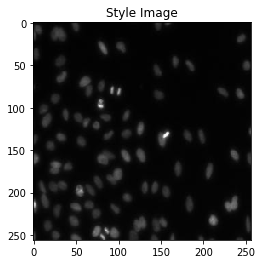

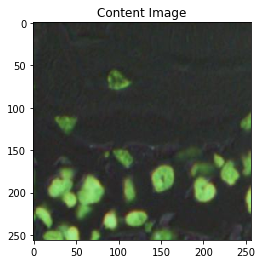

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

## Content & Style losses

Below we define the pytorch modules that help us compute our losses. Since they just return their input, we'll be able to sequentially insert them into the **VGG19** model and all our losses will automatically be computed during the forward pass.

In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion((input * self.weight).expand_as(self.target),
                                   self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

    
class GramMatrix(nn.Module):

    def forward(self, input):
        batch_size, feature_maps, height, width = input.size()

        # flatten the feature maps
        features = input.view(batch_size, feature_maps, height * width)
        
        # compute the gram product
        # this is BatchSize x FeatureMaps x FeatureMaps
        G = torch.bmm(features, features.transpose(1, 2))

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(feature_maps * height * width)

    
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        
        # Get the gram matrix of the target
        # This is B x F x F
        self.gram_target = self.gram(target).detach()
        self.gram_target.mul_(self.weight)

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G.expand_as(self.gram_target),
                                   self.gram_target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

## Load the neural network

Now we can load the pretrained **VGG19** model. This is a 19 layer deep convolutional neural network trained on the 1 million images from the ImageNet challenge. Since we only care about the convolutional layers, we grab those using the model's `features` attribute.

In [5]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

With our pretrained feature extractor, we want to insert our content and style losses between the convolutional layers. To do this, we'll reconstruct **VGG19** from its layers, inserting the content and style losses at specified locations.

In [6]:
content_layers_default = {'conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'}
style_layers_default = {'conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'}

def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1500, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    logging.info("Style weight is %s" % style_weight)
    logging.info("Content weight is %s" % content_weight)
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of 
    # content/syle losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)
            logging.info("Added layer %s" % name)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
                # Pop it off the set of layers for content losses
                content_layers_default.remove(name)
                logging.info("Added content loss to layer %s" % name)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                style_loss = StyleLoss(target_feature, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                # Pop it off the set of layers for style losses
                style_layers_default.remove(name)
                logging.info("Added style loss to layer %s" % name)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)
            logging.info("Added layer %s" % name)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
                # Pop it off the set of layers for content losses
                content_layers_default.remove(name)
                logging.info("Added content loss to layer %s" % name)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                style_loss = StyleLoss(target_feature, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                # Pop it off the set of layers for style losses
                style_layers_default.remove(name)
                logging.info("Added style loss to layer %s" % name)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)
            logging.info("Added layer %s" % name)
        
        # If we've added all of our content and style losses, we're done
        if len(content_layers_default) == len(style_layers_default) == 0:
            break
            
    return model, style_losses, content_losses

## The Input Image

As our input image we take an image of the same dimensions as the content and style images. This image can be a white noise, or it can also be a copy of the content-image. We'll use the latter, for simplicity

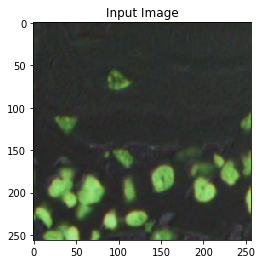

In [7]:
input_img = content_img.clone()
# In comment the line below to use white noise:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')

## Gradient Descent

Just like the [original paper and implementation](https://github.com/leongatys/PytorchNeuralStyleTransfer), by Leon Gatys, suggested, we'll use the L-BFGS algorithm for gradient descent. Keep in mind, we're **not** actually training any neural network, we're training the **input image** so that it minimizes the content and style losses.

In [8]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a 
    # gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

## Putting it all together

Now that we have all of our pieces setup, we can put it together and run the style transfer algorithm. We'll pass the optimizer a closure function so it can reevaluate the model and get the loss between steps.

There is one small caveat we have to be careful of. The optimized image can take on values from $-\infty$ to $\infty$ instead of from $0$ to $1$. This means that, our optimized image can take on non-sensical values. To fix this problem we restrict our image to the domain $[0, 1]$.

In [9]:
def run_style_transfer(cnn, content_img, style_img, input_img, 
                       num_steps=1000, style_weight=1500, 
                       content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    style_scores = []
    content_scores = []
    best_score = [float("inf")]
    best_scores = [float("inf"), float("inf")]
    best_image = [None]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            style_scores.append(style_score.data[0])
            content_scores.append(content_score.data[0])
            if style_scores[-1] + content_scores[-1] <= best_score[0]:
                # print("Best scores improved from - Content: {} - Style: {} "  \
                #       "to - Content: {} - Style: {}".format(best_scores[0], best_scores[1], content_scores[-1], style_scores[-1]))
                best_image[0] = input_param.clone()
                best_score[0] = style_scores[-1] + content_scores[-1]
                best_scores[0] = content_scores[-1]
                best_scores[1] = style_scores[-1]
            if run[0] % 50 == 0:
                logging.info("run {}:".format(run))
                logging.info('Best Style Loss : {:4f} Best Content Loss: {:4f}'.format(
                    best_scores[1], best_scores[0]))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    best_image[0].data.clamp_(0, 1)

    logging.info("Best Scores - Content: {} - Style: {}".format(best_scores[0], best_scores[1]))

    plt.plot(style_scores)
    plt.title("Style score optimization")
    plt.show()

    plt.plot(content_scores)
    plt.title("Content score optimization")
    plt.show()

    return best_image[0].data

Finally we can run the algorithm

2018-04-09 21:21:18,082 : INFO : Style weight is 1500
2018-04-09 21:21:18,083 : INFO : Content weight is 1
2018-04-09 21:21:18,090 : INFO : Added layer conv_1


Building the style transfer model..


2018-04-09 21:21:18,544 : INFO : Added content loss to layer conv_1
2018-04-09 21:21:18,694 : INFO : Added style loss to layer conv_1
2018-04-09 21:21:18,694 : INFO : Added layer relu_1
2018-04-09 21:21:18,695 : INFO : Added layer conv_2
2018-04-09 21:21:18,698 : INFO : Added content loss to layer conv_2
2018-04-09 21:21:18,703 : INFO : Added style loss to layer conv_2
2018-04-09 21:21:18,703 : INFO : Added layer relu_2
2018-04-09 21:21:18,704 : INFO : Added layer pool_3
2018-04-09 21:21:18,704 : INFO : Added layer conv_3
2018-04-09 21:21:18,709 : INFO : Added content loss to layer conv_3
2018-04-09 21:21:18,719 : INFO : Added style loss to layer conv_3
2018-04-09 21:21:18,719 : INFO : Added layer relu_3
2018-04-09 21:21:18,720 : INFO : Added layer conv_4
2018-04-09 21:21:18,729 : INFO : Added content loss to layer conv_4
2018-04-09 21:21:18,740 : INFO : Added style loss to layer conv_4
2018-04-09 21:21:18,742 : INFO : Added layer relu_4
2018-04-09 21:21:18,742 : INFO : Added layer poo

Optimizing..


2018-04-09 21:21:22,996 : INFO : run [50]:
2018-04-09 21:21:22,997 : INFO : Best Style Loss : 1.505665 Best Content Loss: 1.417003


2018-04-09 21:21:41,543 : INFO : run [100]:
2018-04-09 21:21:41,544 : INFO : Best Style Loss : 0.346392 Best Content Loss: 1.452353


2018-04-09 21:22:01,054 : INFO : run [150]:
2018-04-09 21:22:01,055 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:22:19,164 : INFO : run [200]:
2018-04-09 21:22:19,165 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:22:37,149 : INFO : run [250]:
2018-04-09 21:22:37,152 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:22:55,250 : INFO : run [300]:
2018-04-09 21:22:55,253 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:23:13,085 : INFO : run [350]:
2018-04-09 21:23:13,086 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:23:31,161 : INFO : run [400]:
2018-04-09 21:23:31,163 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:23:49,204 : INFO : run [450]:
2018-04-09 21:23:49,206 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:24:07,089 : INFO : run [500]:
2018-04-09 21:24:07,090 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:24:24,796 : INFO : run [550]:
2018-04-09 21:24:24,798 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:24:42,462 : INFO : run [600]:
2018-04-09 21:24:42,464 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:25:00,155 : INFO : run [650]:
2018-04-09 21:25:00,157 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:25:17,852 : INFO : run [700]:
2018-04-09 21:25:17,853 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:25:35,619 : INFO : run [750]:
2018-04-09 21:25:35,621 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:25:53,525 : INFO : run [800]:
2018-04-09 21:25:53,527 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:26:11,751 : INFO : run [850]:
2018-04-09 21:26:11,752 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:26:29,585 : INFO : run [900]:
2018-04-09 21:26:29,587 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:26:47,534 : INFO : run [950]:
2018-04-09 21:26:47,537 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:27:05,833 : INFO : run [1000]:
2018-04-09 21:27:05,835 : INFO : Best Style Loss : 0.261661 Best Content Loss: 1.375898


2018-04-09 21:27:06,211 : INFO : Best Scores - Content: 1.3758978843688965 - Style: 0.261661171913147


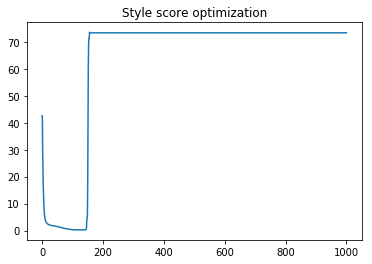

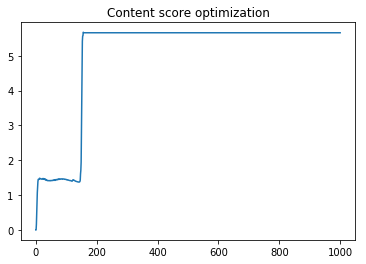

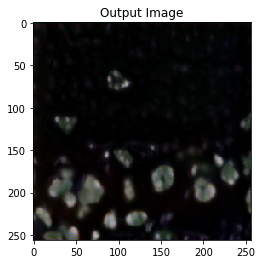

In [10]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

# Save the output
if use_cuda:
    output = output.cpu()

unloader(output.squeeze(0)).save("transferred.png")

plt.figure()
imshow(output, title='Output Image')

We've got some decent results already, though there is a greenish tint to the nuclei still. However, note that the background has been effectively removed which should make it way easier for our models to learn from.

## Next Steps

The results look promising, but there's still more that we can do. Here's an outline of a few modifications we plan on making:

* Here we only used 1 style image, but we actually have roughly 500 images belonging to the style we want to transfer. We could instead perform the style transfer using a batch of style images. This would work by averaging the style loss between the content image and each style image in the batch
* To even make this more efficient, we could theoretically vectorize this process for multiple input images. This will allow us to style transfer all of our data more efficiently
* Though the results look promising, we have yet to plug this into our models. The plan is to include these images as additional filters so the model still has access to the original image, but can use the style transferred version to help.